# Predicting Online Review Ratings of Pizzarias Using Review Photos 

Ziv Branstein 301782215

Avishai Fuss 332658608

## Scraping
As discussed in the project proposal Yelp's dataset does not include photos of reviews, so we had to scrape the photos for our project.
For the project proposal we used a basic web scraper, after analyzing the web traffic we used the same requests as their website to download the photos of reviews found in the dataset. This worked well, however, after a few hundred reviews scraped we encountered a consistent "503 service unavailable" response, checking their website revealed that we were blocked:
![Yelp's ip block](https://github.com/shaifuss/data_science_seminar/blob/master/yelp-ip-address-ban.jpg?raw=1)
After disconnecting from the internet and acquiring a new IP address the website was working again, meaning the blocking was done based on the IP.
This was a real problem, as there are 479792 reviews in total, and using only a few hundred photos for the project will not produce meaningful results.
After getting blocked again we tested the mobile application and it was still operating, giving hope for a new direction for scraping.
Analyzing the traffic for the mobile application was a bit more cumbersome - Yelp's app uses SSL pinning(a technique which prevents man-in-the-middle attack for reading the traffic) that needed to be disabled. Also, the HTTP requests performed by the app were signed using logic run inside the app which needed to be reverse engineered.
The signature algorithm of the android app uses HMAC-SHA1 on the query string with a key embedded in the binary.

The scraping process is performed as follows: 
```
review_scaper.py -> image_scraper.py -> pizza_classifier_xception.py
review_scraper.py: For each review it scrapes the urls of the images of the review.
image_scraper.py: Given the scraped urls it downloads the photos
pizza_classifier_xception.py: Deletes photos which are not classified as pizza in the top 5 results for the Xception classifier
```
After reverse engineering the signature mechanism we retested the scraping and managed to scrape all 1 star reviews from the dataset and a similar amount of 5 star reviews.
After filtering for images of pizzas only (using the pretrained network Xception) we are left with 14,566 photos of pizzas.

## Results

In [80]:
%%capture
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.ERROR)

from collections import defaultdict
from IPython.display import Image
from scipy.stats import binom
from shutil import copyfile, move
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras import backend as K
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from traceback import format_exc
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pprint
import random
import seaborn as sns 
import tensorflow
import tensorflow.keras.applications
import time

!pip install pyspellchecker -q
!pip install sentence-transformers -q

# Fix random for consistent results
def fix_random():
    np.random.seed(42)
    random.seed(42)
    tensorflow.random.set_seed(42)
fix_random()

In [81]:
if not os.path.exists('review_photos'):
    if os.path.exists('data_science_seminar'):
        %cd data_science_seminar
    else:
        !git clone https://github.com/shaifuss/data_science_seminar.git
        %cd data_science_seminar
if (not os.path.exists('yelp_academic_dataset_business.json')) or (not os.path.exists('yelp_academic_dataset_review.json')):
    kaggle_path = os.path.expanduser('~/.kaggle')
    kaggle_json_path = os.path.join(kaggle_path, 'kaggle.json')
    if not os.path.exists(kaggle_json_path):
        from getpass import getpass
        kaggle_json = getpass('Insert kaggle.json:')
        os.makedirs(kaggle_path, exist_ok=True)
        with open(kaggle_json_path, 'w') as f:
            f.write(kaggle_json)
        os.chmod(kaggle_json_path, 0o600)
    !kaggle datasets download yelp-dataset/yelp-dataset
    !unzip yelp-dataset.zip yelp_academic_dataset_business.json yelp_academic_dataset_review.json
    !rm yelp-dataset.zip

In [82]:
business_df = pd.read_json('yelp_academic_dataset_business.json', lines=True)
print("The dataset contains a total of {} businesses".format(len(business_df.index)))

The dataset contains a total of 209393 businesses


In [83]:
business_df = business_df[business_df['categories'].notna()]
pizza_biz_df = business_df[business_df['categories'].str.contains("Pizza")]
print("Of those, {} businesses sell pizza".format(len(pizza_biz_df.index)))
print("Here are a few examples")
pizza_biz_df.head()

Of those, 7302 businesses sell pizza
Here are a few examples


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
63,ZkzutF0P_u0C0yTulwaHkA,Lelulos Pizzeria,311 Unity Center Rd,Plum,PA,15239,40.489996,-79.779288,4.0,31,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Restaurants, Pizza","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ..."
86,OWkS1FXNJbozn-qPg3LWxg,Mama Napoli Pizza,,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,1,"{'RestaurantsDelivery': 'False', 'BusinessAcce...","Food, Food Trucks, Restaurants, Pizza",{'Friday': '18:0-0:0'}
105,-C0AlwLuXpcP609madJZQQ,Pizzaville,"1030 Kennedy Circle, Unit 10",Milton,ON,L9T 0J9,43.508962,-79.837990,3.5,7,1,None,"Restaurants, Pizza","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ..."
120,39lLJK_rrYY2NYomSsQdUA,Marco's Pizza,24335 Chagrin Blvd,Beachwood,OH,44122,41.465789,-81.506349,2.5,11,1,"{'RestaurantsDelivery': 'True', 'GoodForKids':...","Restaurants, Pizza",None
126,0y6alZmSLnPzmG5_kP5Quw,J J's Pizza,20542 Lorain Rd,Fairview Park,OH,44126,41.448341,-81.847644,4.5,21,1,"{'NoiseLevel': 'u'quiet'', 'WiFi': ''no'', 'Bu...","Pizza, Italian, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."


In [84]:
pizza_business_ids = set(pizza_biz_df.business_id)
pizza_reviews = []
with open('yelp_academic_dataset_review.json', 'r') as f:
    for line in f:
        line_json = json.loads(line)
        if line_json['business_id'] in pizza_business_ids:
            pizza_reviews.append(line_json)
print(f"And a total of {len(pizza_reviews)} reviews")

And a total of 479792 reviews


In [85]:
review_ids_with_photos = list(os.listdir("review_photos"))
pizza_reviews_by_id = {pizza_review["review_id"]: pizza_review for pizza_review in pizza_reviews}
output_path = "review_photos_by_stars"
os.makedirs(os.path.join(output_path, "0"), exist_ok=True)
os.makedirs(os.path.join(output_path, "1"), exist_ok=True)
for review_id_with_photos in review_ids_with_photos:
    review_path = os.path.join("review_photos", review_id_with_photos)
    if pizza_reviews_by_id[review_id_with_photos]["stars"] in [1.0, 5.0]:
        for filename in os.listdir(review_path):
            img_path = os.path.join(review_path, filename)
            copyfile(img_path, os.path.join(output_path, str((int(pizza_reviews_by_id[review_id_with_photos]["stars"]) - 1) // 4), f"{review_id_with_photos}_{filename}"))

In [86]:
len(os.listdir(os.path.join(output_path, "0"))), len(os.listdir(os.path.join(output_path, "1")))

(4320, 10246)

We are left wtih 4,320 photos from 1-star reviews and 10,246 photos of 5 star reviews. To make training and evaluation easier, we will drop the excess of 5 star review photos.

In [87]:
for _ in range(max(0, len(os.listdir(os.path.join(output_path, "1"))) - len(os.listdir(os.path.join(output_path, "0"))))):
    os.unlink(os.path.join(output_path, "1", np.random.choice(os.listdir(os.path.join(output_path, "1")))))

In [88]:
len(os.listdir(os.path.join(output_path, "0"))), len(os.listdir(os.path.join(output_path, "1")))

(4320, 4320)

We will split the data for training, validation and test sets with 60%:20%:20% respectively. Unlike the proposal, the dataset no longer fits the RAM so we will prepare directories for each subset and feed the model from disk.

In [89]:
def split_train_validation_test(input_path, output_path, seed=42):
    np.random.seed(seed)
    subsets = ["train", "val", "test"]
    train_samples = 0
    validation_samples = 0
    test_samples = 0
    for subset in subsets:
        os.makedirs(os.path.join(output_path, subset, "0"), exist_ok=True)
        os.makedirs(os.path.join(output_path, subset, "1"), exist_ok=True)
    for class_name in os.listdir(input_path):
        class_samples = os.listdir(os.path.join(input_path, class_name))
        np.random.shuffle(class_samples)
        for class_sample in class_samples[:int(len(class_samples) * 0.6)]:
            move(os.path.join(input_path, class_name, class_sample), os.path.join(output_path, "train", class_name, class_sample))
            train_samples += 1
        for class_sample in class_samples[int(len(class_samples) * 0.6):int(len(class_samples) * 0.8)]:
            move(os.path.join(input_path, class_name, class_sample), os.path.join(output_path, "val", class_name, class_sample))
            validation_samples += 1
        for class_sample in class_samples[int(len(class_samples) * 0.8):]:
            move(os.path.join(input_path, class_name, class_sample), os.path.join(output_path, "test", class_name, class_sample))
            test_samples += 1
    print(f"Splitted data into [training={train_samples}, validation={validation_samples}, test={test_samples}]")
        
split_train_validation_test("review_photos_by_stars", "review_photos_split")

Splitted data into [training=5184, validation=1728, test=1728]


We will now try to compare different available pretrained models on our validation set. We will assume the best pretrained model will perform well with other architectures as well.

In [90]:
%%capture
DEFAULT_INPUT_SIZE = 500
pretrained_networks =  [
  ('DenseNet121', tensorflow.keras.applications.densenet.preprocess_input),
  ('DenseNet169', tensorflow.keras.applications.densenet.preprocess_input),
  ('DenseNet201', tensorflow.keras.applications.densenet.preprocess_input),
  ('InceptionResNetV2', tensorflow.keras.applications.inception_resnet_v2.preprocess_input),
  ('InceptionV3', tensorflow.keras.applications.inception_v3.preprocess_input),
  ('MobileNet', tensorflow.keras.applications.mobilenet.preprocess_input),
  ('MobileNetV2', tensorflow.keras.applications.mobilenet_v2.preprocess_input),
  ('NASNetLarge', tensorflow.keras.applications.nasnet.preprocess_input),
  ('NASNetMobile', tensorflow.keras.applications.nasnet.preprocess_input),
  ('ResNet101', tensorflow.keras.applications.resnet.preprocess_input),
  ('ResNet101V2', tensorflow.keras.applications.resnet_v2.preprocess_input),
  ('ResNet152', tensorflow.keras.applications.resnet.preprocess_input),
  ('ResNet152V2', tensorflow.keras.applications.resnet_v2.preprocess_input),
  ('ResNet50', tensorflow.keras.applications.resnet50.preprocess_input),
  ('ResNet50V2', tensorflow.keras.applications.resnet_v2.preprocess_input),
  ('VGG16', tensorflow.keras.applications.vgg16.preprocess_input),
  ('VGG19', tensorflow.keras.applications.vgg19.preprocess_input),
  ('Xception', tensorflow.keras.applications.xception.preprocess_input)
]
patience = 5
BATCH_SIZE = 64
pretrained_network_results = {}
for (pretrained_network_name, pretrained_network_preprocessing) in pretrained_networks:
    fix_random()
    K.clear_session()
    try:
        pretrained_network = getattr(tensorflow.keras.applications, pretrained_network_name)
        try:
            input_shape = (DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE)
            base_model = pretrained_network(include_top=False, pooling='avg', input_shape=(input_shape[0], input_shape[1], 3))
        except Exception:
            # Maybe the model has a specific input shape
            base_model = pretrained_network(include_top=False, pooling='avg')
            input_shape = (base_model.input_shape[1], base_model.input_shape[2])
        train_generator = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.densenet.preprocess_input).flow_from_directory(
            directory="review_photos_split/train", 
            class_mode="binary", 
            target_size=input_shape, 
            batch_size=BATCH_SIZE, 
            shuffle=False
        )
        X_train = base_model.predict(train_generator, batch_size=BATCH_SIZE)
        y_train = train_generator.classes
        validation_generator = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.densenet.preprocess_input).flow_from_directory(
            directory="review_photos_split/val", 
            class_mode="binary", 
            target_size=input_shape, 
            batch_size=BATCH_SIZE, 
            shuffle=False
        )
        X_validation = base_model.predict(validation_generator, batch_size=BATCH_SIZE)
        y_validation = validation_generator.classes
        K.clear_session()
        input_layer = Input(shape=(base_model.output_shape[1], ))
        x = Dense(8, activation='relu')(input_layer)
        predictions = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=input_layer, outputs=predictions)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
        h = model.fit(
            X_train,
            y_train,
            validation_data = (X_validation, y_validation), 
            batch_size=BATCH_SIZE,
            epochs=1000, 
            callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
            verbose=0
        )
        pretrained_network_results[pretrained_network_name] = h.history['val_accuracy'][-patience - 1]
    except Exception:
      print(f"Warning - failed to execute {pretrained_network_name}: {format_exc()}")

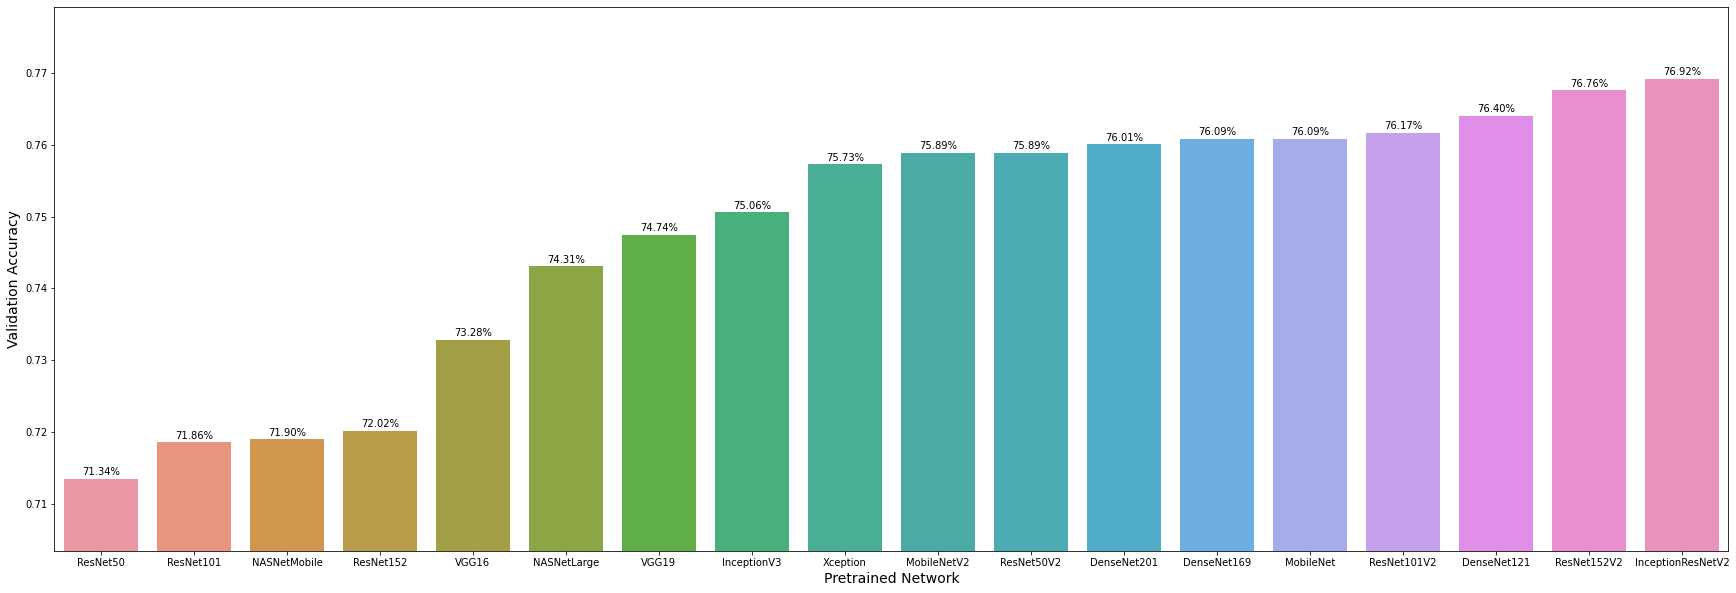

In [91]:
plt.figure(figsize=(30, 10))
sorted_pretrained_network_results = sorted(pretrained_network_results.items(), key=lambda result_item: result_item[1])
barplot = sns.barplot(x=[network_name for (network_name, _) in sorted_pretrained_network_results], y=[network_result for (_, network_result) in sorted_pretrained_network_results])
_, pretrained_network_result_values = zip(*sorted_pretrained_network_results)
barplot.set(ylim=(min(pretrained_network_result_values) - 0.01, max(pretrained_network_result_values) + 0.01))
plt.ylabel("Validation Accuracy", fontsize=14)
plt.xlabel("Pretrained Network", fontsize=14)
for i, p in enumerate(barplot.patches):
    barplot.text(i, p.get_height() + 0.0005, '%.2f%%' % (sorted_pretrained_network_results[i][1] * 100, ), color='black', ha="center")

As you can see DenseNet201 performed the best on our validation set.
From now on we will use the extracted features from DenseNet201 as the input for different algorithms:

### Neural network

In [92]:
K.clear_session()
# Create the base pre-trained model
base_model = tensorflow.keras.applications.DenseNet201(include_top=False, input_shape=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE, 3), pooling='avg')

BATCH_SIZE = 128
train_generator = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory="review_photos_split/train", 
    class_mode="binary", 
    target_size=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)
validation_generator = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory="review_photos_split/val", 
    class_mode="binary", 
    target_size=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)
test_generator = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory="review_photos_split/test", 
    class_mode="binary", 
    target_size=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)
# Precalculate extracted features for the different sets once to save time
X_train = base_model.predict(train_generator, batch_size=BATCH_SIZE)
y_train = train_generator.classes
X_validation = base_model.predict(validation_generator, batch_size=BATCH_SIZE)
y_validation = validation_generator.classes
X_test = base_model.predict(test_generator, batch_size=BATCH_SIZE)
y_test = test_generator.classes

Found 7120 images belonging to 2 classes.
Found 2530 images belonging to 2 classes.
Found 2508 images belonging to 2 classes.


We will try to use a Dropout layer to avoid overfitting on the training set. 

We also decided to drop the data augmentation, since it made the training very slow and we didn't see a significant improvement.

In [93]:
fix_random()
patience = 15
BATCH_SIZE = 128
input_layer = Input(shape=(base_model.output_shape[1], ))
x = Dropout(0.5)(input_layer)
x = Dense(8, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

h = model.fit(
    X_train, y_train,
    validation_data = (X_validation, y_validation), 
    epochs=1000, 
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
    verbose=0
)
print(f"Best epoch: loss: {h.history['loss'][-patience - 1]}, accuracy: {h.history['accuracy'][-patience - 1]}, val_loss: {h.history['val_loss'][-patience - 1]}, val_accuracy: {h.history['val_accuracy'][-patience - 1]}")

Best epoch: loss: 0.5076374411582947, accuracy: 0.7542135119438171, val_loss: 0.4903593957424164, val_accuracy: 0.7624505758285522


We can see an improvement over the original result.

Let's try to fine-tune the model to further improve the results. We will recreate the model with the trained weights, unfreeze the last few layers in the base model, and use a low learning rate to avoid destroying the pretrained model:

In [94]:
K.clear_session()
input_layer = Input(shape=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE, 3))
x = Dense(8, activation='relu')(base_model(input_layer, training=False))
predictions = Dense(1, activation='sigmoid')(x)
fine_tune_model = Model(inputs=input_layer, outputs=predictions)
fine_tune_model.layers[-1].set_weights(model.layers[-1].get_weights())
fine_tune_model.layers[-2].set_weights(model.layers[-2].get_weights())
for layer in base_model.layers[:-9]:
    layer.trainable = False
fine_tune_model.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=["accuracy"])

BATCH_SIZE = 128
patience = 3
train_generator = ImageDataGenerator(
    preprocessing_function=tensorflow.keras.applications.densenet.preprocess_input,
).flow_from_directory(
    directory="review_photos_split/train", 
    class_mode="binary", 
    target_size=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE), 
    batch_size=BATCH_SIZE, 
    seed=42
)
validation_generator = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory="review_photos_split/val", 
    class_mode="binary", 
    target_size=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE), 
    batch_size=BATCH_SIZE, 
    seed=42
)
h = fine_tune_model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs=1000, 
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
    verbose=0
)
print(f"Best epoch: loss: {h.history['loss'][-patience - 1]}, accuracy: {h.history['accuracy'][-patience - 1]}, val_loss: {h.history['val_loss'][-patience - 1]}, val_accuracy: {h.history['val_accuracy'][-patience - 1]}")

Found 7120 images belonging to 2 classes.
Found 2530 images belonging to 2 classes.
Best epoch: loss: 0.4530452489852905, accuracy: 0.7916190028190613, val_loss: 0.4883386194705963, val_accuracy: 0.7648026347160339


### Support vector machine

In [95]:
fix_random()
svm = SVC()
svm.fit(X_train, y_train)
y_validation_predicted = svm.predict(X_validation)
print(f"Validation accuracy for SVM over pretrained model is: {np.sum(y_validation_predicted == y_validation) / y_validation.shape[0]}")

Validation accuracy for SVM over pretrained model is: 0.7849802371541502


SVM performed better than the neural network on the validation set. Let's see if it has the same accuracy on the test set:

In [96]:
y_test_predicted = svm.predict(X_test)
print(f"Test accuracy for the SVM over pretrained model is: {np.sum(y_test_predicted == y_test) / y_test.shape[0]}")
pd.DataFrame(confusion_matrix(y_test, y_test_predicted), index=['True: 1 star', 'True: 5 stars'], columns=['Predicted: 1 star', 'Predicted: 5 stars'])

Test accuracy for the SVM over pretrained model is: 0.79585326953748


,Predicted: 1 star,Predicted: 5 stars
True: 1 star,505,359
True: 5 stars,153,1491


It seems like the test set accuracy is similar to the validation accuracy which probably indicates that the model has generalized pretty well. 

In [97]:
# Free memory for the next section
del base_model
del model
del fine_tune_model
del svm
del X_train
del y_train
del X_validation
del y_validation
del X_test
del y_test
K.clear_session()

### NLP Filtering

In this section we aim to identify distinct topics discussed in the corpus of pizza review texts. Once topics are identified, reviews that do not contain food-related topics can be filtered out. This has the potential to improve the image classification in the next stage by weeding out irrelevent samples - where reviewers didn't base their scores on the pizza. 

This will be achieved by building a topic model that categorizes the information present in each review. A topic can be modeled as a set of words that are all related. For instance, we might say that [noise, smell, music, dirt, lighting] reflects the topic of restaurant atmosphere.  

The first algorithm we will utilize is latent Dirichlet allocation. The premise of LDA (Biel et al., 2003) is that documents with similar topics use similar words. The algorithm aims to discover groups of words the occur frequently occur together in the same document. A topic is modeled as a probability distribution over words. Moreover, a document can be modeled as a probability distribution over different topics. 

Thus, the algorithm works as follows:

1.   Remove unimportant words and set how many topics to find.
2.   Randomly assign each word in each document to a random topic
3.   For each document,
>a. choose a topic, assuming all others are allocated correctly

>>i. calculate the topic distribution within the document:  p(topic | document)

>>ii. calculate the word distribution within the topic: p(word | topic)

>> iii. multiply i and ii together and assign words to new topics based on the result

4. terminate when there are no new assignments

The LDA model is finetuned by several parameters:
Alpha reflects how many topics are in a given document (higher values lead to more topics per document in the model)
Beta reflects how many words are in a given topic (higher values lead to more words per topic in the model). In this implementation, the model is set to learn these values automatically.

We compare the pure LDA model with a hybrid version that utilizes sentence embeddings of the review texts crafted by BERT (Devlin et al., 2018). Inspiration for this hybrid model comes from https://blog.insightdatascience.com/contextual-topic-identification-4291d256a032.

BERT is a pretrained language model from researchers at Google that utilizes a multiheaded transformer ANN architecture to craft word vectors that learns to capture the meaning of words from the context in which they are found. BERT and its successors have acheived impressive performance on language understatnding tasks like question answering and others. 

The hybrid model attempted here fuses the topic probability vector from LDA with the review text embedding from BERT to create a hybrid sample. Since the BERT vectors are much larger that the LDA vectors, scaling is performed on the LDA vectors to even out their relative importance. 

Clustering is then performed to distinguish different topics in the corpus (the default algorithm used here is KMeans). The most frequent words in the cluster become the topic. 

 


Preprocessing is necessary to create a universal vocabulary for the corpus. Each text is first processed at the string level and then at the word level. 

Examples:
1. fix typos and missing spaces
2. remove punctuation, capitalization, and numbers
3. remove unimportant words (stopwords)
4. stem words so that a fair comparison can be made (for example, salted and salty both become salt)

For the sake of brevity, the preproccessing functions are contained in a seperate script located at:
https://github.com/shaifuss/data_science_seminar/blob/master/preproccessing.py

In an attempt to improve the clustering for the hybrid model, dimensionality reduction is performed. An autoencoder is trained on the LDA+BERT vectors. Once training is complete, the middle hidden layer of length 32 is taken as a representation of the original data. This achieves compression of at least 25x. 

Clustering is performed on the compressed vectors. After clustering, topics are constructed from the top 5 most frequent words in each cluster.

For the hybrid model, BERT outputs sentence-level encodings of length 768 (the first output vector corresponding to the CLS token passed in at the start of each text). An LDA vector contains a probability value in range [0.0, 1.0] for each possible topic. 



In [98]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


class Autoencoder:
    """
    Autoencoder for learning latent space representation
    architecture simplified for only one hidden layer
    """

    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
import gensim

# define model object
class Topic_Model:
    def __init__(self, method, k=4):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'LDA', 'BERT', 'LDA_BERT'}:
            raise Exception('Invalid method!')
        self.k = k
        self.dictionary = None
        self.corpus = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 250  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + str(round(time.time(),0))

    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vector representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20, alpha='auto', )

            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            return vec

        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer('bert-base-nli-max-tokens')
            vec = np.array(model.encode(sentences, show_progress_bar=True))
            return vec

        #         elif method == 'LDA_BERT':
        else: 
            vec_lda = self.vectorize(sentences, token_lists, method='LDA')
            vec_bert = self.vectorize(sentences, token_lists, method='BERT')
            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
            self.vec['LDA_BERT_FULL'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
                print('Fitting Autoencoder ...')
                self.AE.fit(vec_ldabert)
            vec = self.AE.encoder.predict(vec_ldabert)
            return vec

    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        ####################################################
        #### Getting ldamodel or vector representations ####
        ####################################################

        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary
                                                                , alpha='auto', eta='auto', minimum_probability=0.3)
        else:
            print('Clustering embeddings ...')
            self.cluster_model = m_clustering(self.k)
            self.vec[method] = self.vectorize(sentences, token_lists, method)
            self.cluster_model.fit(self.vec[method])

    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        # Default as False
        out_of_sample = out_of_sample is not None

        print("Predicting...")
        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            if self.method != 'LDA':
                vec = self.vectorize(sentences, token_lists)
                print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get(self.method, None)

        if self.method == "LDA":   # take the most prevalent topic
            #lbs = np.array(list(map(lambda x: sorted(self.ldamodel.get_document_topics(x),
                                                     #key=lambda x: x[1], reverse=True)[0][0], corpus)))
            lbs = []
            for text in corpus:
              lbs.append(self.ldamodel.get_document_topics(text))
        else:
            lbs = self.cluster_model.predict(vec)
        return lbs
    def persist(self, workdir):
      with open(os.path.join(workdir, "test_" + self.id), 'wb') as f:
        pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)

Coherence is used for topic model evaluation (Roder et al., 2015). As topic models produced algorithmically are sometimes not easily interpreted by humans, it is necessary to have a way to objectively measure how well the words in a topic go together. 

Very generally, coherence can be evaluated for a topic by first computing a Cartesian product on itself to construct pairs (excluding twin pairs). The co-occurence of each pair is checked in an external reference - a very large corpus of texts said to represent common language usage. The higher the co-occurence scores, the higher the topic coherence.

We hypothesize that the following four topics are relevant to pizza reviews.

1. Food
2. Service
3. Atmosphere
4. Value

Adding +/- 1, we train models with 3, 4, and 5 topics for each method. 


In [100]:
def train(method, ntopic, sentences, token_lists, idx_in):
  
  print("Starting training...")
  start = time.time()
  tm = Topic_Model(method, k = ntopic)
  tm.fit(sentences, token_lists)
  end = time.time()
  print("Training on {} reviews took {} minutes".format(len(sentences), str((end - start)/60)))
  
  return tm


In [ ]:
import preprocessing
import postprocess

pic_path = 'review_photos'
pix_review_ids = [f for f in os.listdir(pic_path) if os.path.isdir(os.path.join(pic_path, f))]

text_df = pd.DataFrame.from_records(pizza_reviews)

pic_review_df = text_df[text_df['review_id'].isin(pix_review_ids)]
pic_review_df = pic_review_df.reset_index(drop=True)
pic_review_df = pic_review_df.fillna('')
reviews = pic_review_df.text

sentences, token_lists, idx_in = preprocessing.preprocess(reviews, len(reviews) + 1)

model_dict = dict()
for method in ["LDA", "LDA_BERT"]:
  for num_topics in range(3, 6):
    tm = train(method, num_topics, sentences, token_lists, idx_in)
    model_dict[method + "_" + str(num_topics)] = dict()
    model_dict[method + "_" + str(num_topics)]["model"] = tm
    model_dict[method + "_" + str(num_topics)]["coherence"] = postprocess.get_coherence(tm, token_lists, 'c_v')
    model_dict[method + "_" + str(num_topics)]["silhouette"] = postprocess.get_silhouette(tm)
    if method == "LDA":
      model_dict[method + "_" + str(num_topics)]["topics"] = postprocess.get_topic_words_lda(tm)
    else:
      model_dict[method + "_" + str(num_topics)]["topics"] = postprocess.get_topic_words_hybrid(token_lists, tm.cluster_model.labels_, k=None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Stage 1: Preprocess raw review texts


Evaluation

1. Coherence was consistently an order of magnitude higher for the pure LDA model, a gap that widened as larger datasets were used.
2. Silhoutte scores improved as the LDA vectors were weighted more heavily in the hybrid model (not shown in this notebook)
3. The pure LDA model produced higher quality topics as judged by two human evaluators (us). 



In [ ]:
stemmed_pizza_vocab = preprocessing.stem_words(["crust", "slice", "sauce", "topping", "cheese", "tomato", "food", "pie"])
model_dict = postprocess.get_scores(model_dict, stemmed_pizza_vocab)
best_method = max(model_dict, key=lambda v: model_dict[v]['coherence'])
best_topic = max(range(len(model_dict[best_method]["scores"])), key=model_dict[best_method]["scores"].__getitem__)
print("best method is {}".format(best_method))
print("best_topic is at index {}".format(best_topic))

For prediction, the topics are retrieved for a given review. If the best pizza topic is not the most prominent topic in that review, our hypothesis is that discarding it will lead to improved performance for the image classifier. This would be the ideal filter. However, due to constaints on the size of the dataset, we eliminate reviews where the pizza topic is below a minimum threshold instead.



In [ ]:
import random

topic_lists = model_dict[best_method]["model"].predict(sentences, token_lists, True)
indicies = []
for i, topic_list in enumerate(topic_lists):
  topics = [x[0] for x in topic_list]
  if best_topic in topics:
    indicies.append(i)

food_based_reviews = pic_review_df[pic_review_df.index.isin(indicies)]
print("Example reviews that passed the filter:\n")
print(food_based_reviews.loc[random.choice(indicies), "text"])
print("---------------------------------------------------------------")
print(food_based_reviews.loc[random.choice(indicies), "text"])

In [ ]:
food_based_review_ids = set(food_based_reviews["review_id"].values)

In [ ]:
review_ids_with_photos = list(os.listdir("review_photos"))
pizza_reviews_by_id = {pizza_review["review_id"]: pizza_review for pizza_review in pizza_reviews}
output_path = "filtered_review_photos_by_stars"
os.makedirs(os.path.join(output_path, "0"), exist_ok=True)
os.makedirs(os.path.join(output_path, "1"), exist_ok=True)
for review_id_with_photos in review_ids_with_photos:
    review_path = os.path.join("review_photos", review_id_with_photos)
    if review_id_with_photos not in food_based_review_ids:
        # Filter non food based reviews 
        continue
    if pizza_reviews_by_id[review_id_with_photos]["stars"] in [1.0, 5.0]:
        for filename in os.listdir(review_path):
            img_path = os.path.join(review_path, filename)
            copyfile(img_path, os.path.join(output_path, str((int(pizza_reviews_by_id[review_id_with_photos]["stars"]) - 1) // 4), f"{review_id_with_photos}_{filename}"))

In [ ]:
len(os.listdir(os.path.join(output_path, "0"))), len(os.listdir(os.path.join(output_path, "1")))

In [ ]:
for _ in range(max(0, len(os.listdir(os.path.join(output_path, "1"))) - len(os.listdir(os.path.join(output_path, "0"))))):
    os.unlink(os.path.join(output_path, "1", np.random.choice(os.listdir(os.path.join(output_path, "1")))))

In [ ]:
len(os.listdir(os.path.join(output_path, "0"))), len(os.listdir(os.path.join(output_path, "1")))

In [ ]:
split_train_validation_test("filtered_review_photos_by_stars", "filtered_review_photos_split")

In [ ]:
K.clear_session()
# Create the base pre-trained model
base_model = tensorflow.keras.applications.DenseNet201(include_top=False, input_shape=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE, 3), pooling='avg')

BATCH_SIZE = 128
train_generator = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory="filtered_review_photos_split/train", 
    class_mode="binary", 
    target_size=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)
validation_generator = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory="filtered_review_photos_split/val", 
    class_mode="binary", 
    target_size=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)
test_generator = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory="filtered_review_photos_split/test", 
    class_mode="binary", 
    target_size=(DEFAULT_INPUT_SIZE, DEFAULT_INPUT_SIZE), 
    batch_size=BATCH_SIZE, 
    shuffle=False
)
# Precalculate extracted features for the different sets once to save time
X_train = base_model.predict(train_generator, batch_size=BATCH_SIZE)
y_train = train_generator.classes
X_validation = base_model.predict(validation_generator, batch_size=BATCH_SIZE)
y_validation = validation_generator.classes
X_test = base_model.predict(test_generator, batch_size=BATCH_SIZE)
y_test = test_generator.classes

In [ ]:
fix_random()
svm = SVC()
svm.fit(X_train, y_train)
y_validation_predicted = svm.predict(X_validation)
print(f"Validation accuracy for SVM over pretrained model is: {np.sum(y_validation_predicted == y_validation) / y_validation.shape[0]}")

In [ ]:
y_test_predicted = svm.predict(X_test)
print(f"Test accuracy for the SVM over pretrained model is: {np.sum(y_test_predicted == y_test) / y_test.shape[0]}")
pd.DataFrame(confusion_matrix(y_test, y_test_predicted), index=['True: 1 star', 'True: 5 stars'], columns=['Predicted: 1 star', 'Predicted: 5 stars'])

## Discussion

Review rating prediction (RRP) is the branch of research studying the connection between reviews and ratings. Most commonly, Review texts are used to predict either a multi-class rating classification or regression model. Two main approaches appear in the literature.

The first uses review texts alone. Using the same YELP dataset, Ashgar et al. (2016) compared many different NLP methods to perform multi-class classification.

The second approach attempts to combine textual inputs with other information available from the review. Wang and colleagues (2016) created a model that combines review texts with author habits. 

In this project, we go in a different direction. We place the focus on the visual information from the reviews and incorporate the textual information in support. We hypothesize that product images can be the driving factor for gleaning information about ratings. 

A Yelp restaurant review encompasses the entire dining experience; taste, presentation, portion size, service, atmosphere, quality, price, ambience and more. Other factors more abstract influences include: each reviewer weighs factors differently, outside influences on the reviewer’s mood that day, variations in cultural rating habits, varied levels of photography skills, to name a few. Considering all of this, it’s not a foregone conclusion that a connection between presentation and rating exists. Even if it does, it’s quite a daunting task to find it.


## Conclusions

We achieved over 75% accuracy both on the validation and test sets(compared to the 69% on the much smaller dataset in the proposal) with image classification alone. The matching results for both sets indicate that the model has indeed learned a generalizable connection between images and ratings.
Even so, there's room for improvement, one reason being that our resources were limited (e.g. we omitted data augmentation to fit the data in the given execution limit).

The dataset contains nearly 480,000 texts. Ideally we would have liked to use them all to build the models but the computational costs became prohibitive. As mentioned above, scraping images was a significant obstacle in curating this self-made dataset.

While building the NLP model, we used ~60,000 reviews which we preprocessed over a 12 hour period and persisted to disk. For the final version, we were required to run the notebook consecutively from beginning to end. Given the constraints of the environment (Google Colab), were only able to use the 10304 reviews for which we scraped images.

The impact of the relatively small dataset was most evident when choosing the filtering condition. We originally planned on retaining only reviews whose top-rated topic was the pizza topic. However, this filtered out 90% of the data. Instead, we filtered out the reviews where the pizza topic didn’t pass a minimum threshold. Obviously, this condition is much less strict and served to hamper the potential of NLP filtering. 

In both the image classification portion and the NLP portion, a modern neural network approach is compared with a more “traditional” algorithm. Surprisingly, both times the traditional algorithm performed best. For the NLP, this may be because the LDA Bayesian-based algorithm was specifically crafted for the task while the clustering hybrid model may have been learning other aspects inherent in the data. 

As presently constructed, an experience with 20 photos carried more influence than a review with 1 photo. This is because each photo was treated as a separate sample. Further work should consider multiple instance learning to control for this.

The model has to learn to discount reviews that put little weight on appearance – a tendency of the review author. Hypothetically, multiple instance learning could also help with this.
